# Predicting car accident severity using machine learning

This notebook will be used to develop the capstone project of the IBM Certification in Data Science.

The purpose of this project is to predict accident using attributes collected by the Seattle Polive Department and recorded by Traffic Records.


Original dataset: [link_dataset](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv)  
Metadata: [link_metadata](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)

In order to get the most out of this dataset, I followed the 


## Table of Contents

### 1 - [Business Understanding](#business-und)

### 2 - [Data understanding and Data Preparation](#data-und-data-prep)

### 3 - [Modeling](#modeling)

### 4 - [Evaluation](#evaluation)

### 5 - [Conclusion](#conclusion)

In [1]:
##### Import necessary packages
import sklearn
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

# Ploting params
plt.rcParams['axes.titlesize'] = 14
# axes.titlesize : 24
# axes.labelsize : 20
# lines.linewidth : 3
# lines.markersize : 10
# xtick.labelsize : 16
# ytick.labelsize : 16

# 1 - Business Understanding

[Backstory]

This project my be relevant if the Department of Transport of Seattle intends to develop actions to reduce the number of accidents associated with human injuries.

During the past 15 years the Department of Transport collected data that can be used to predict the kind of accident that is associated with certain conditions.  

Public policy can then use the results of the model and develop actions that can target specific city areas or specific road infrastructures to reduce the frequency of accidents.

The successful outcome would be a model that can predict with accuracy accidents of severity 2 (with human costs), so that actions can be developed (target adversiting, road panels with 'attention', more police deployement to secure roads, etc) to minimize the costs. False predicts of class 1 would not be problematic the objective of this model is to target efforts to reduce overal road accidents as some of the accidents are unpredictable on their own.


<a id="data-und-data-prep"><a/>

# 2 - Data understanding and Data Preparation

    
#### First step is to load the data.

In [2]:
# specify the location of the data
data_url = 'https://github.com/joseferncruz/coursera-capstone/raw/master/datasets/collisions_data.csv'#r'C:\Users\josec\Desktop\github_repos\coursera-capstone\datasets\collisions_data.csv'

# load the data into a dataframe
df_raw = pd.read_csv(
    data_url,
    parse_dates=['INCDTTM', 'INCDATE'], # Parse dates to datetime objects  
);


C:\Users\josec\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Let's start by exploring the features and characteristics of this dataset.

In [3]:
print(f'This dataset has {df_raw.shape[0]} rows and {df_raw.shape[1]} columns, including one target column.')

This dataset has 194673 rows and 38 columns, including one target column.


In [4]:
# display some information about the datatypes and number of entries associated with the full raw dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   SEVERITYCODE    194673 non-null  int64              
 1   X               189339 non-null  float64            
 2   Y               189339 non-null  float64            
 3   OBJECTID        194673 non-null  int64              
 4   INCKEY          194673 non-null  int64              
 5   COLDETKEY       194673 non-null  int64              
 6   REPORTNO        194673 non-null  object             
 7   STATUS          194673 non-null  object             
 8   ADDRTYPE        192747 non-null  object             
 9   INTKEY          65070 non-null   float64            
 10  LOCATION        191996 non-null  object             
 11  EXCEPTRSNCODE   84811 non-null   object             
 12  EXCEPTRSNDESC   5638 non-null    object             
 13  SEVERITYCODE.1

By exploring the metadata, it is possible to notice that some columns have large quantities of missing data or lack information (Not Enough Information or NEI). Also our model should be able to predict accident severity based on features (ie information) than can be measured in real time or within hour range (eg weather, road conditiong, etc).  

In [200]:
# Drop columns not used in this case study
df = df_raw.drop(columns=[
    'STATUS',
    'REPORTNO',       # Report number    
    'SEGLANEKEY',     # A key for the lane segment in which the collision occurred.
    'ST_COLDESC',     # A description that corresponds to the state’s coding designation
    'ST_COLCODE',     # A code provided by the state that describes the collision. For more information about these codes, please see the State Collision Code Dictionary.
    'SDOTCOLNUM',     # A number given to the collision by SDOT
    'LOCATION',       # Detailed description of the location
    'INTKEY',         # Key that corresponds to the intersection associated with a collision
    'OBJECTID',       # ESRI unique identifier
    'EXCEPTRSNCODE',  # NEI||
    'EXCEPTRSNDESC',  # NEI
    'SDOT_COLCODE',   # Code from the SDOT
    'SDOT_COLDESC',   # Meaning of the code
    'INATTENTIONIND', # Inattention > large amounts of missing data
    'COLLISIONTYPE',  # Collision type
    'INCKEY',         # Unique key for the incident  
    'COLDETKEY',      # Secondary key for the incident 
    'SEVERITYCODE.1', # duplicate column    
    'PEDROWNOTGRNT',  # Whether or not the pedestrian right of way was not granted. (Y/N)
    'SPEEDING',       # Too many missing data
    'INCDATE',        # Information already containned in 'INCDTTM'     
    'HITPARKEDCAR',   # Hit parked car
    'UNDERINFL',      # Under influence of alchool
    'SEVERITYDESC',   # Description of the severity, same info as SEVERITYCODE
]).copy()

#### In order to solve this classification problem, I will use the following features from the original dataset:


|Attributes| Description|  
|---:|:----|  
|SEVERITYCODE|A code that corresponds to the severity of the collision|  
| X | GPS Latitude coordinate |
| Y | GPS Longitude coordinate | 
|ADDRTYPE|Collision address type|
|PERSONCOUNT|The total number of people involved in the collision|
|PEDCOUNT|The number of pedestrians involved in the collision |
|PEDCYLCOUNT| The number of bicycles involved in the collision. |
|VEHCOUNT|The number of vehicles involved inthe collision|
|INCDTTM|The date and time of the incident.|
| JUNCTIONTYPE| Category of junction at which collision took place |
|WEATHER|A description of the weather conditions during the time of the collision|
|ROADCOND|The condition of the road during the collision|
|LIGHTCOND|The light conditions during the collision|
|CROSSWALKKEY| A key for the crosswalk at which the collision occurred |


In [201]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'ADDRTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INCDTTM', 'JUNCTIONTYPE', 'WEATHER',
       'ROADCOND', 'LIGHTCOND', 'CROSSWALKKEY'],
      dtype='object')

#### The first step is to remove missing/unknown information from columns in order to reduce the uncertainty around certain features. In this project I will consider only observations that have complete, unambigous information. 

In [202]:
# Remove entries with missing information
df.dropna(inplace=True)

# Remove missing/uncertain values from WEATHER
cond = df['WEATHER'].isin(['Unknown', 'Other'])
df = df.loc[~cond, :].copy()

# Remove missing/uncertain values from ROADCOND
cond = df['ROADCOND'].isin(['Unknown', 'Other'])
df = df.loc[~cond, :].copy()

# Remove missing/uncertain values from LIGHTCOND
cond = df['LIGHTCOND'].isin(['Unknown', 'Other', 'Dark - Unknown Lighting'])
df = df.loc[~cond, :].copy()

# JUNTIONTYPE
cond = df['JUNCTIONTYPE'].isin(['Unknown'])
df = df.loc[~cond, :]

# Remove alleys from address type due to low samples
df = df.loc[~df['ADDRTYPE'].isin(['Alley']), :].copy()

# remove events with missing hour 
# Extract the hour
df['HOUR'] = df['INCDTTM'].dt.hour
# remove faulty entries (ie not correct hour record)
cond = df['HOUR'].isin([0])
df = df.loc[~cond, :].copy()

In [203]:
# Display information about the dataset without missing data or incomplete information.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139535 entries, 0 to 194672
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   SEVERITYCODE  139535 non-null  int64         
 1   X             139535 non-null  float64       
 2   Y             139535 non-null  float64       
 3   ADDRTYPE      139535 non-null  object        
 4   PERSONCOUNT   139535 non-null  int64         
 5   PEDCOUNT      139535 non-null  int64         
 6   PEDCYLCOUNT   139535 non-null  int64         
 7   VEHCOUNT      139535 non-null  int64         
 8   INCDTTM       139535 non-null  datetime64[ns]
 9   JUNCTIONTYPE  139535 non-null  object        
 10  WEATHER       139535 non-null  object        
 11  ROADCOND      139535 non-null  object        
 12  LIGHTCOND     139535 non-null  object        
 13  CROSSWALKKEY  139535 non-null  int64         
 14  HOUR          139535 non-null  int64         
dtypes: datetime64[ns]

The `SEVERITYCODE` target variable can take 2 values (1/2):
- 1: **Property Damage**  
- 2: **Injury**




In [204]:
# How many observations per target category exists?
for category, counts in df.SEVERITYCODE.value_counts().items():
    print(f"There are {counts} elements in target value {category}.")
    
# Print normalized count in each category of severity.
norm_count = df.SEVERITYCODE.value_counts(normalize=True).to_dict()
print(f"The dataset is devided into{norm_count.get(1)*100: 0.2f}% Severity 1 and{norm_count.get(2)*100: 0.2f}% Severity 2 observations.")

There are 92765 elements in target value 1.
There are 46770 elements in target value 2.
The dataset is devided into 66.48% Severity 1 and 33.52% Severity 2 observations.


#### As it is possible to observe, our dataset is quite imbalanced and this poses a challenge to classification algorithms. For now, we will consider the full dataset (ie records without missing or ambigous information) and I will address later the problem of the imbalanced data.

# Location of type 1 and type 2 severity events in the city of Seattle

#### Since we have GPS Data, the first step will be to cluster the city of seattle into 10 different spatial clusters and identify those clusters. This information can also be relevant for the sponsors to target their actions to reduce accident severity.

In [205]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'ADDRTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INCDTTM', 'JUNCTIONTYPE', 'WEATHER',
       'ROADCOND', 'LIGHTCOND', 'CROSSWALKKEY', 'HOUR'],
      dtype='object')

## Divide the city of Seattle into 12 clusters

In [206]:
from sklearn.cluster import KMeans

# Initiate KMeans for 10 clusters (ie putative city areas)
kmeans = KMeans(n_clusters = 12, init ='k-means++', random_state=32)

# Get coords dataframe
coords = df[['X', 'Y']]

# Fit the model
kmeans.fit(coords) # Compute k-means clustering.

# get the labels
labels = kmeans.predict(coords) # Labels of each point

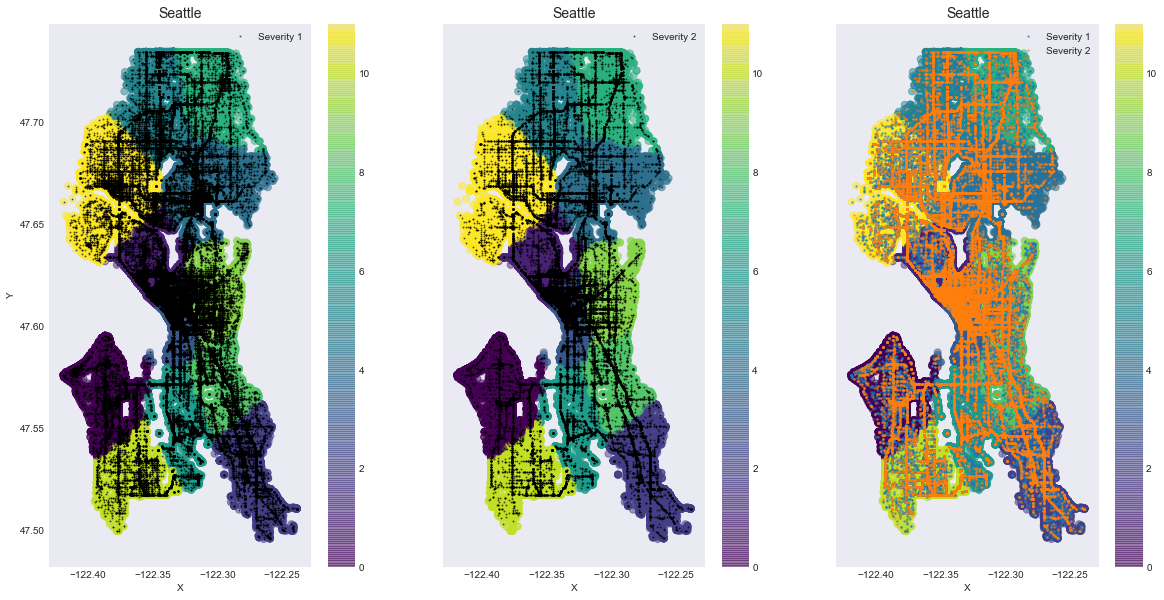

In [207]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Set condition to access both types of severity independently
cond = df['SEVERITYCODE'] == 1

# Class 1
ax[0].plot(df['X'][cond], df['Y'][cond], '.', ms=2, alpha=0.5, color='black')
ax[0].set(ylabel='Latitude')
ax[0].legend(labels=['Severity 1'])

# Class 2
ax[1].plot(df['X'][~cond], df['Y'][~cond], '.', ms=2, color='black', alpha=0.5)
ax[1].legend(labels=['Severity 2'])

# Both 1 and 2
for event_type in [1, 2]:
    ax[2].plot(df['X'][df['SEVERITYCODE'] == event_type], df['Y'][df['SEVERITYCODE'] == event_type], '.', ms=3, alpha=0.5)
ax[2].legend(labels=['Severity 1', 'Severity 2'], loc='upper right')

# Complete plot info
for idx in range(3):
    ax[idx].set(title='Seattle')
    ax[idx].set(xlabel='Longitude')
    ax[idx].tick_params('x', labelrotation=45)
    
    coords.plot.scatter(x = 'X', y = 'Y', c=labels, s=50, cmap='viridis', ax=ax[idx], alpha=0.5)

In [208]:
# Create a new feature: `SECTOR_ID` with labels from the clustering algorithm.
df['SECTOR_ID'] = labels

In [209]:
# Check the total numbe of severity 1 and 2 events for each sector
result = df.groupby(['SEVERITYCODE'])['SECTOR_ID'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()
result.sort_values('NORM_COUNT', inplace=True)

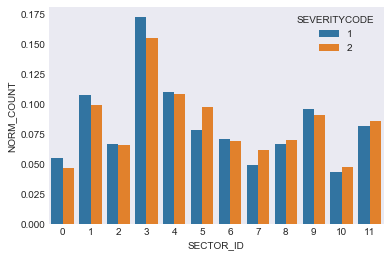

In [210]:
sns.barplot(x='SECTOR_ID', y='NORM_COUNT', data=result, hue='SEVERITYCODE', )

#### It seems that Sector 5 and 7 have higher proportion of accident severity 2. This information can be used with one-hot encoder to create 2 more variables `SECTOR_5` and `SECTOR_7`

In [211]:
df['SECTOR_5'] = df['SECTOR_ID'].apply(lambda x: 1 if x == 5 else 0)
df['SECTOR_7'] = df['SECTOR_ID'].apply(lambda x: 1 if x == 5 else 0)

## When do events of specific severities happen more often?
---
#### In order to answer this question, we need to create new time features from the time feature in `INCDTTM`.

In [212]:
# Extract the week day
df['WEEKDAY'] = df['INCDTTM'].dt.weekday

# Extract the hour
df['HOUR'] = df['INCDTTM'].dt.hour

# Extrack the month
df['MONTH'] = df['INCDTTM'].dt.month

# Extract the year
df['YEAR'] = df['INCDTTM'].dt.year

# Display top 3 columns
df.head(3)

,SEVERITYCODE,X,Y,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,JUNCTIONTYPE,...,ROADCOND,LIGHTCOND,CROSSWALKKEY,HOUR,SECTOR_ID,SECTOR_5,SECTOR_7,WEEKDAY,MONTH,YEAR
0,2,-122.323148,47.703140,Intersection,2,0,0,2,2013-03-27 14:54:00,At Intersection (intersection related),...,Wet,Daylight,0,14,7,0,0,2,3,2013
1,1,-122.347294,47.647172,Block,2,0,0,2,2006-12-20 18:55:00,Mid-Block (not related to intersection),...,Wet,Dark - Street Lights On,0,18,1,0,0,2,12,2006
2,1,-122.334540,47.607871,Block,4,0,0,3,2004-11-18 10:20:00,Mid-Block (not related to intersection),...,Dry,Daylight,0,10,3,0,0,3,11,2004


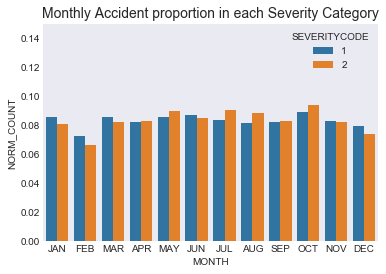

In [213]:
# Extract monthly normalized count of events for each category
result = df.groupby('SEVERITYCODE')['MONTH'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()
sns.barplot(x='MONTH', y='NORM_COUNT', data=result, hue='SEVERITYCODE', ax=ax)

month_labels = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ax.set(ylim=(0, 0.15), xticklabels=month_labels, title='Monthly Accident proportion in each Severity Category');

#### It seems that **JULY** and **AUGUST** have a (low, but still) slightly higher proportion of accidents in the category 2. We could used this information to create one additional one-hot encoded variable `SUMMER`.

In [214]:
df['SUMMER'] = df['MONTH'].apply(lambda x: 1 if x in [6, 7] else 0)

In [215]:
# Show the proportion.
df.groupby('SEVERITYCODE')['SUMMER'].value_counts(normalize=True)

SEVERITYCODE  SUMMER
1             0         0.828923
              1         0.171077
2             0         0.824503
              1         0.175497
Name: SUMMER, dtype: float64

## What about daily modulation in accident severity? Is there a particular time of the day with higher proportion of accidents belonging to a specific severity?
----


[Text(0.5, 1.0, 'Hourly accident proportion in each severity Category')]

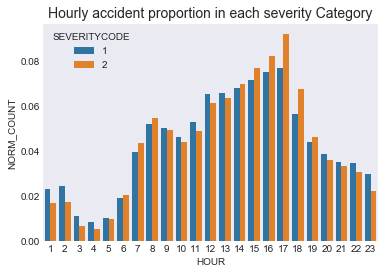

In [216]:
# Estract normalized count of each severity category for each hour
result = df.groupby('SEVERITYCODE')['HOUR'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()

fig, ax = plt.subplots()

sns.barplot(x='HOUR', y='NORM_COUNT', data=result, hue='SEVERITYCODE', ax=ax)

ax.set(title='Hourly accident proportion in each severity Category')

#### It seems that during the afternoon there higher a higher proportion of accidents belonging to category 2, particularly during the rush rour (5-7PM). Let's capture this variation in another one-hot encoded variable `AFTERNOON`. 

In [217]:
df['AFTERNOON'] = df['HOUR'].apply(lambda x: 1 if x in [14, 15, 16, 17, 18] else 0)

df.groupby('SEVERITYCODE')['AFTERNOON'].value_counts(normalize=True)

SEVERITYCODE  AFTERNOON
1             0            0.651808
              1            0.348192
2             0            0.611524
              1            0.388476
Name: AFTERNOON, dtype: float64

## What is the average human cost associated with each city sector?
---
#### In order to maximize the clustering information, it would be good to find a measure of human cost that could be used to describe each individual group (ie `SECTOR_ID`). One way to do this is to explore a measurement of the ratio between of humans vs vehicles involved. 

In [218]:
# Create a single column that agregates all the non-motorized human involvement
df['TOTAL_HUMAN'] = df[['PERSONCOUNT', 'PEDCYLCOUNT', 'PEDCOUNT']].sum(axis=1)
df['TOTAL_HUMAN'].head()

0    2
1    2
2    4
3    3
4    2
Name: TOTAL_HUMAN, dtype: int64

## What is the relationship between total number of people involved and total number of vehicles involved?  

#### Before dwelling into to the relation, let's have a look at the distribution of values within each variable.

In [219]:
# Some stats about severity and location
df.groupby(['SEVERITYCODE'])[['VEHCOUNT', 'TOTAL_HUMAN']].agg([np.mean, np.min, np.max])

VEHCOUNT           TOTAL_HUMAN          
                  mean amin amax        mean amin amax
SEVERITYCODE                                          
1             2.008419    0   12    2.413949    0   57
2             1.900962    0   11    2.925764    0   81

#### It seems that a higher number of people is associated with a severity of type 2, alghouth the mean is only slightly lower. Let's look at the distribution.

C:\Users\josec\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\josec\anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
C:\Users\josec\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
C:\Users\josec\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


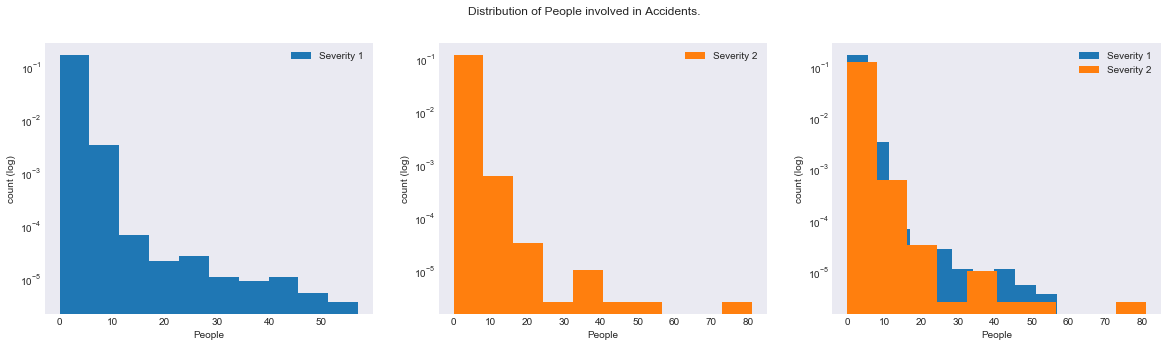

In [220]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distribution of People involved in Accidents.')

bins = 10 

ax[0].hist(df['TOTAL_HUMAN'][df['SEVERITYCODE']==1], log=True, bins=bins, color='#1f77b4', label='Severity 1', normed=True);
ax[1].hist(df['TOTAL_HUMAN'][df['SEVERITYCODE']==2], log=True, bins=bins, color='#ff7f0e', label='Severity 2', normed=True);

ax[2].hist(df['TOTAL_HUMAN'][df['SEVERITYCODE']==1], log=True, bins=bins, color='#1f77b4', label='Severity 1', normed=True);
ax[2].hist(df['TOTAL_HUMAN'][df['SEVERITYCODE']==2], log=True, bins=bins, color='#ff7f0e', label='Severity 2', normed=True);

for idx in range(3):
    ax[idx].legend()
    ax[idx].set(ylabel='count (log)', xlabel='People')

In [221]:
result = df.groupby(['SEVERITYCODE', 'SECTOR_ID']).mean()[['TOTAL_HUMAN', 'VEHCOUNT']].reset_index()

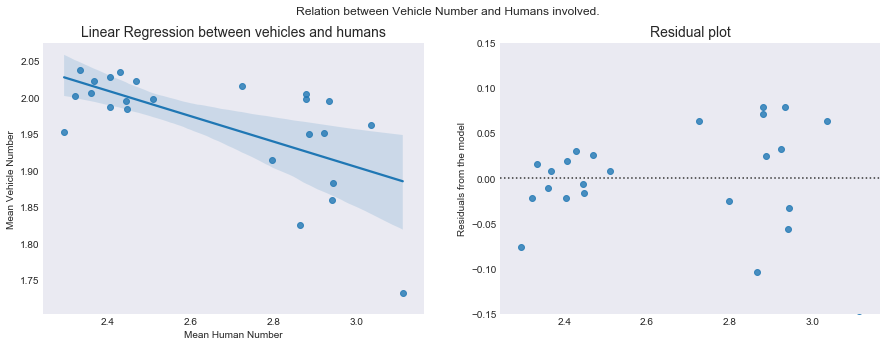

In [222]:
# Plot the relation between total number of people involved vs vehicles.
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Relation between Vehicle Number and Humans involved.')

sns.regplot(
    x='TOTAL_HUMAN',
    y='VEHCOUNT',
    data=result,
    order=1,
    ax=ax[0]
)
ax[0].set(
    ylabel='Mean Vehicle Number',
    xlabel='Mean Human Number',
    title='Linear Regression between vehicles and humans')

sns.residplot(
    x='TOTAL_HUMAN',
    y='VEHCOUNT',
    data=result,
    order=1,
    ax=ax[1]
)
ax[1].set(
    title='Residual plot',
    ylabel='Residuals from the model',
    xlabel='',
    ylim=(-0.15, 0.15));

### Are the two variables correlated?
----

In [223]:
slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(result[['TOTAL_HUMAN', 'VEHCOUNT']])

print(f"The correlation coeff (person) is: {rvalue: 0.2f} and the p-value associated is {pvalue: 0.3f}")

The correlation coeff (person) is: -0.64 and the p-value associated is  0.001


#### The two variables are negatively correlated, meaning that there is a higher number of people associated with accidents involving fewer vehicles. 

## What is the ratio between total number of people involved and number of vehicles?
---

#### Let's now calculate the ratio between people involved and vehicles involved for each observation in the dataset.



In [224]:
# Add small value to VEH count to avoid ZeroDivisionError 
df[['VEHCOUNT']] = df[['VEHCOUNT']] + 0.001

# Divide total_human by veh_count
df['RATIO_HUMAN/VEH'] = df['TOTAL_HUMAN'].div(df['VEHCOUNT'])

#### Now let's check the mean of the `RATIO_HUMAN/VEH` of each Cluster and for each severity catergory.

In [225]:
human_cost = df.groupby(['SEVERITYCODE', 'SECTOR_ID']).mean()['RATIO_HUMAN/VEH'].to_frame().reset_index()

human_cost.head()

,SEVERITYCODE,SECTOR_ID,RATIO_HUMAN/VEH
0,1,0,1.171744
1,1,1,1.236594
2,1,2,1.248108
3,1,3,1.649418
4,1,4,1.602570


#### Let's Create a new feature called `SECTOR_HUMAN_COST` which stores the score of human cost for each sector.

In [226]:
severity_code_1 = human_cost[human_cost['SEVERITYCODE']==1][['SECTOR_ID', 'RATIO_HUMAN/VEH']]
severity_code_1 = severity_code_1.to_dict().get('RATIO_HUMAN/VEH')

severity_code_2 = human_cost[human_cost['SEVERITYCODE']==2][['SECTOR_ID', 'RATIO_HUMAN/VEH']].reset_index()
severity_code_2 = severity_code_2.to_dict().get('RATIO_HUMAN/VEH')

In [227]:
# 
df['SECTOR_HUMAN_COST_a'] = df[df['SEVERITYCODE']==1]['SECTOR_ID'].replace(severity_code_1)
df['SECTOR_HUMAN_COST_a'].fillna(0, inplace=True)

In [228]:
df['SECTOR_HUMAN_COST_b'] = df[df['SEVERITYCODE']==2]['SECTOR_ID'].replace(severity_code_2)
df['SECTOR_HUMAN_COST_b'].fillna(0, inplace=True)

In [229]:
df['SECTOR_HUMAN_COST'] = df['SECTOR_HUMAN_COST_a'] + df['SECTOR_HUMAN_COST_b']

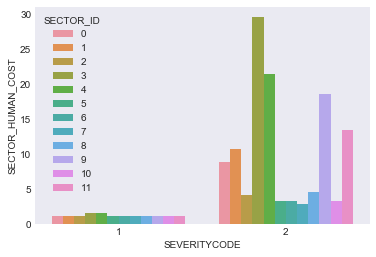

In [230]:
sns.barplot(x='SEVERITYCODE', y='SECTOR_HUMAN_COST', data=df, hue='SECTOR_ID')

#### Create a unifrom value to define each cluster.

In [231]:
net_human_cost = human_cost['RATIO_HUMAN/VEH'][human_cost['SEVERITYCODE']==2].reset_index(drop=True)\
                 - human_cost['RATIO_HUMAN/VEH'][human_cost['SEVERITYCODE']==1]

In [232]:
# Set up new variable 
df['SECTOR_HUMAN_COST'] = df['SECTOR_ID'].replace(net_human_cost.to_dict())

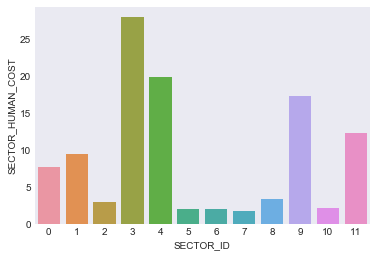

In [233]:
# Plot the results 
sns.barplot(
    x='SECTOR_ID',
    y='SECTOR_HUMAN_COST',
    data=df
)

In [234]:
df['TOTAL_INTERV'] = df['TOTAL_HUMAN'] + df['VEHCOUNT']

## Are specific types of road structures involved in specific types of events?
---
#### Among the data choosen to build the model, we can find information about types of collision addresses: Intersection and Block. 


[(0, 1),
 Text(0, 0.5, 'Normalized count'),
 Text(0.5, 0, 'Collision address type'),
 Text(0.5, 1.0, 'Accident severity and collision address type')]

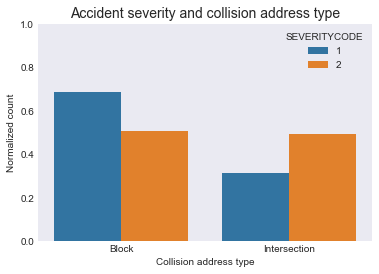

In [235]:
result = df.groupby(['SEVERITYCODE'])['ADDRTYPE'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()

fig, ax = plt.subplots()
sns.barplot(
    data=result, 
    x='ADDRTYPE', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
    ax=ax
)

ax.set(
    title='Accident severity and collision address type', 
    ylabel='Normalized count', 
    xlabel='Collision address type',
    ylim=(0, 1)
)

#### It seems that Severity type 2 accidents happen in equally proportions in both Blocks and Intersections whereas type 1 accidents tend to happen more in Blocks.

## What about the road condition? How does road condition relate to accident severity?
---
There are several different attributes in terms of road condition, for instance:

In [236]:
print('Different states of road conditions', df.ROADCOND.unique())

Different states of road conditions ['Wet' 'Dry' 'Ice' 'Snow/Slush' 'Sand/Mud/Dirt' 'Standing Water' 'Oil']


[Text(0, 0.5, 'normalized count'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Road conditions and accident severity')]

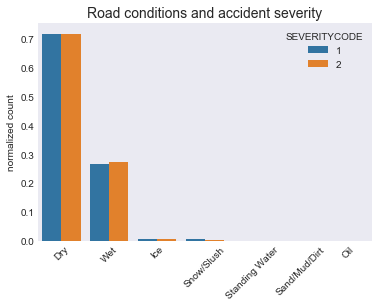

In [237]:
result = df.groupby(['SEVERITYCODE'])['ROADCOND'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='ROADCOND', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)
ax.tick_params('x', labelrotation=45)
ax.set(title='Road conditions and accident severity', ylabel='normalized count', xlabel='')

#### It seems that there are no striking differences between road conditions and the different types of accident severity. In order to decrease the number of different categories, we will bin some of the variables with similar conditions.

In [238]:
dry = ['Dry']
wet = ['Wet', 'Ice', "Snow/Slush", 'Sand/Mud/Dirt', 'Standing Water', 'Oil']


for word in wet:
    df['ROADCOND'] = df['ROADCOND'].replace(word, 'wet')
for word in dry:
    df['ROADCOND'] = df['ROADCOND'].replace(word, 'dry')
    
df.groupby('SEVERITYCODE').ROADCOND.value_counts(normalize=True)

SEVERITYCODE  ROADCOND
1             dry         0.718180
              wet         0.281820
2             dry         0.717319
              wet         0.282681
Name: ROADCOND, dtype: float64

In [239]:
df.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts(normalize=True)

SEVERITYCODE  LIGHTCOND               
1             Daylight                    0.670770
              Dark - Street Lights On     0.267396
              Dusk                        0.032879
              Dawn                        0.013885
              Dark - No Street Lights     0.008829
              Dark - Street Lights Off    0.006242
2             Daylight                    0.697049
              Dark - Street Lights On     0.243126
              Dusk                        0.034018
              Dawn                        0.014903
              Dark - No Street Lights     0.005495
              Dark - Street Lights Off    0.005409
Name: LIGHTCOND, dtype: float64

#### Another important component that can play a role in accident severity is the lighting conditiong at the time of the accident. 
## Is there any relationship between accident severity and luminosity at the time of the accident?
---
Similarly to road condition, there are several different values associated with this feature. 

In [240]:
df.groupby('SEVERITYCODE').LIGHTCOND.value_counts(normalize=True)

SEVERITYCODE  LIGHTCOND               
1             Daylight                    0.670770
              Dark - Street Lights On     0.267396
              Dusk                        0.032879
              Dawn                        0.013885
              Dark - No Street Lights     0.008829
              Dark - Street Lights Off    0.006242
2             Daylight                    0.697049
              Dark - Street Lights On     0.243126
              Dusk                        0.034018
              Dawn                        0.014903
              Dark - No Street Lights     0.005495
              Dark - Street Lights Off    0.005409
Name: LIGHTCOND, dtype: float64

#### Let's bin the values by good and bad visibility condiitons.

In [241]:
# Group by similar condtions
day_light = ['Daylight']
low_light = ['Dark - Street Lights On', 'Dusk', 'Dawn', 'Dark - No Street Lights', 'Dark - Street Lights Off']

for word in day_light:
    df['LIGHTCOND'] = df['LIGHTCOND'].replace(word, 'light-good')
for word in low_light:
    df['LIGHTCOND'] = df['LIGHTCOND'].replace(word, 'light-bad')
    
df.LIGHTCOND.unique()

array(['light-good', 'light-bad'], dtype=object)

[(0, 1),
 Text(0, 0.5, 'normalized count'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Light conditions and accident severity')]

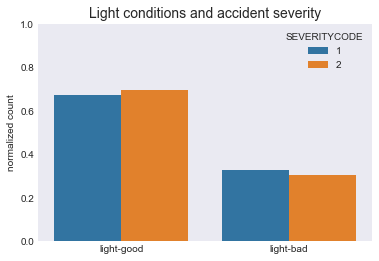

In [242]:
result = df.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='LIGHTCOND', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)

ax.set(ylim=(0, 1), title='Light conditions and accident severity', ylabel='normalized count', xlabel='')

#### It seems that good lightning conditions have slightly higher proportion of accidents of type 2 (ie injury-related). It could be explained for instance buy driver over confidence during a seemingly safer road period (ie daylight).

---
#### While we have observed that Insersections have higher proportion of type 1 accidents, We can explore the feature `JUNCTIONTYPE` to extract more insights about the properties of the accidents.

In [243]:
# Junction Type
df.groupby('SEVERITYCODE').JUNCTIONTYPE.value_counts(normalize=True)

SEVERITYCODE  JUNCTIONTYPE                                     
1             Mid-Block (not related to intersection)              0.503854
              At Intersection (intersection related)               0.303929
              Mid-Block (but intersection related)                 0.120563
              Driveway Junction                                    0.059193
              At Intersection (but not related to intersection)    0.011556
              Ramp Junction                                        0.000906
2             At Intersection (intersection related)               0.483365
              Mid-Block (not related to intersection)              0.330511
              Mid-Block (but intersection related)                 0.118559
              Driveway Junction                                    0.055206
              At Intersection (but not related to intersection)    0.011439
              Ramp Junction                                        0.000919
Name: JUNCTIONTYPE, dtyp

#### It seems that type 1 Severity Accidentds happen 50% of the times at Mid-Blocks whereas type 2 accidents happen with ~48% of the times at Intersection (intersection related). Since getting higher positive rate of type 2 accidents is our priority, I will use this information to create a one-hot encoded feature `INTERSECTION_RELATED` with this informatinon: 

In [244]:
df['INTERSECTION_RELATED'] = df['JUNCTIONTYPE'].apply(lambda x: 1 if x == 'At Intersection (intersection related)' else 0)

## How is weather forecast related to accident severity type?
---
The weather is also an important aspect of safe driving conditions and can have a strong impact on the type of accidents that can place. In our dataset, weather can have the following values:

In [245]:
df['WEATHER'].unique()

array(['Overcast', 'Raining', 'Clear', 'Snowing', 'Fog/Smog/Smoke',
       'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy'], dtype=object)

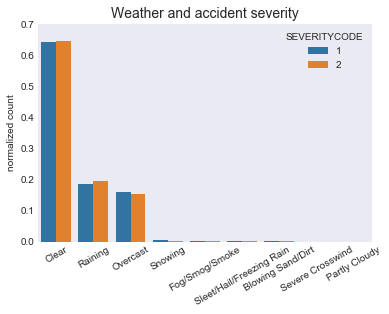

In [246]:
result = df.groupby(['SEVERITYCODE'])['WEATHER'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='WEATHER', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)

ax.set(ylim=(0, 0.7), title='Weather and accident severity', ylabel='normalized count', xlabel='');
ax.tick_params('x', labelrotation=30)

In [247]:
df.groupby('SEVERITYCODE').WEATHER.value_counts(normalize=True)

SEVERITYCODE  WEATHER                 
1             Clear                       0.643066
              Raining                     0.186687
              Overcast                    0.160136
              Snowing                     0.005724
              Fog/Smog/Smoke              0.003309
              Sleet/Hail/Freezing Rain    0.000614
              Blowing Sand/Dirt           0.000269
              Severe Crosswind            0.000172
              Partly Cloudy               0.000022
2             Clear                       0.644580
              Raining                     0.194612
              Overcast                    0.153645
              Fog/Smog/Smoke              0.003357
              Snowing                     0.002908
              Sleet/Hail/Freezing Rain    0.000449
              Blowing Sand/Dirt           0.000257
              Severe Crosswind            0.000128
              Partly Cloudy               0.000064
Name: WEATHER, dtype: float64

#### The vast majority of the accidents (>65%) happen during periods of Clear sky. Let's bin the different categories in: `sunny`, `cloudy` and `rainy-snow`.

In [248]:
# Eeather categories
sunny = ['Clear', ]
cloudy = ['Overcast', 'Fog/Smog/Smoke', 'Partly Cloudy', 'Blowing Sand/Dirt', 'Severe Crosswind', ]
rainy_snow = ['Raining', 'Snowing', 'Sleet/Hail/Freezing Rain', ]

for word in sunny:
    df['WEATHER'] = df['WEATHER'].replace(word, 'sunny')
for word in cloudy:
    df['WEATHER'] = df['WEATHER'].replace(word, 'cloudy')
for word in rainy_snow:
    df['WEATHER'] = df['WEATHER'].replace(word, 'wet')

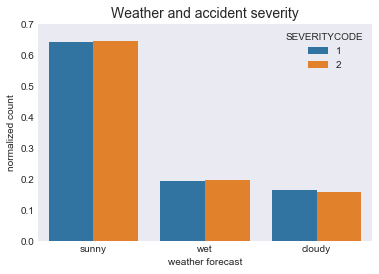

In [249]:
result = df.groupby(['SEVERITYCODE'])['WEATHER'].value_counts(normalize=True).to_frame('NORM_COUNT').reset_index()


fig, ax = plt.subplots()

sns.barplot(
    data=result, 
    x='WEATHER', 
    y='NORM_COUNT', 
    hue='SEVERITYCODE',
)

ax.set(ylim=(0, 0.7), title='Weather and accident severity', ylabel='normalized count', xlabel='weather forecast');

## Accidents at Crosswalks
---
#### Finaly and to complete this basic EDA, let's have a look at the `CROSSWALKKEY` feature. This feature hold the key of the crossroad that is associated with an accident. Let's investigate whether accidents at crosswalks are associated with specific types of accidents. 

In [250]:
# Transform the variable in 1 where there is an event at crossroad (ie accident) or 0 elsewhere.
df['CROSSWALKKEY'] = df['CROSSWALKKEY'].apply(lambda x: 0 if x == 0 else 1)

df.groupby('SEVERITYCODE')['CROSSWALKKEY'].value_counts(normalize=True)

SEVERITYCODE  CROSSWALKKEY
1             0               0.996108
              1               0.003892
2             0               0.936348
              1               0.063652
Name: CROSSWALKKEY, dtype: float64

#### It seems that the majority of the accidents do not take place at crossroads. However, severity 2 accidents tend to associated in higher proportion to crossroads compared to severity 1 accidents.

Select and prepare data for modeling.
---

In [257]:
df = df[['SEVERITYCODE', 'ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
         'CROSSWALKKEY', 'SECTOR_5', 'SECTOR_7', 'WEEKDAY', 'MONTH',
         'AFTERNOON', 'SUMMER', 'TOTAL_HUMAN', 'SECTOR_HUMAN_COST']]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139535 entries, 0 to 194672
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEVERITYCODE       139535 non-null  int64  
 1   ADDRTYPE           139535 non-null  object 
 2   WEATHER            139535 non-null  object 
 3   ROADCOND           139535 non-null  object 
 4   LIGHTCOND          139535 non-null  object 
 5   CROSSWALKKEY       139535 non-null  int64  
 6   SECTOR_5           139535 non-null  int64  
 7   SECTOR_7           139535 non-null  int64  
 8   WEEKDAY            139535 non-null  int64  
 9   MONTH              139535 non-null  int64  
 10  AFTERNOON          139535 non-null  int64  
 11  SUMMER             139535 non-null  int64  
 12  TOTAL_HUMAN        139535 non-null  int64  
 13  SECTOR_HUMAN_COST  139535 non-null  float64
dtypes: float64(1), int64(9), object(4)
memory usage: 21.0+ MB


### One-hot encoding of categorical data
---

In [259]:
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139535 entries, 0 to 194672
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   SEVERITYCODE           139535 non-null  int64  
 1   CROSSWALKKEY           139535 non-null  int64  
 2   SECTOR_5               139535 non-null  int64  
 3   SECTOR_7               139535 non-null  int64  
 4   WEEKDAY                139535 non-null  int64  
 5   MONTH                  139535 non-null  int64  
 6   AFTERNOON              139535 non-null  int64  
 7   SUMMER                 139535 non-null  int64  
 8   TOTAL_HUMAN            139535 non-null  int64  
 9   SECTOR_HUMAN_COST      139535 non-null  float64
 10  ADDRTYPE_Block         139535 non-null  uint8  
 11  ADDRTYPE_Intersection  139535 non-null  uint8  
 12  WEATHER_cloudy         139535 non-null  uint8  
 13  WEATHER_sunny          139535 non-null  uint8  
 14  WEATHER_wet            139535 non-nu

### Balance the dataset
---
#### Implementing a resampling method of the majority class.

In [262]:
from imblearn.under_sampling import RandomUnderSampler # https://imbalanced-learn.readthedocs.io/en/stable/api.html

# Create resampling object 
rus = RandomUnderSampler(replacement=False, random_state=32, sampling_strategy='majority')

# create target bool array to subset dataset
target_cond = df.columns == 'SEVERITYCODE'

# Undersample the data
FEATURES, TARGET = rus.fit_sample(df.loc[:, ~target_cond], df.loc[:, target_cond])

# Reassemble the dataset for preprocessing
FEATURES['SEVERITYCODE'] = TARGET

# Reassign variable to df
df = FEATURES.copy()

# Show the information about undersampled dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93540 entries, 0 to 93539
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CROSSWALKKEY           93540 non-null  int64  
 1   SECTOR_5               93540 non-null  int64  
 2   SECTOR_7               93540 non-null  int64  
 3   WEEKDAY                93540 non-null  int64  
 4   MONTH                  93540 non-null  int64  
 5   AFTERNOON              93540 non-null  int64  
 6   SUMMER                 93540 non-null  int64  
 7   TOTAL_HUMAN            93540 non-null  int64  
 8   SECTOR_HUMAN_COST      93540 non-null  float64
 9   ADDRTYPE_Block         93540 non-null  uint8  
 10  ADDRTYPE_Intersection  93540 non-null  uint8  
 11  WEATHER_cloudy         93540 non-null  uint8  
 12  WEATHER_sunny          93540 non-null  uint8  
 13  WEATHER_wet            93540 non-null  uint8  
 14  ROADCOND_dry           93540 non-null  uint8  
 15  RO

<a id="modeling"><a/>

# Modeling
---

In this problem, I intend to build a binary classifier model based on previous observations. Thus, this problems represents a supervised learning problem and in order to tackle my classification problem I will use 3 types of machine learning algorithms:

- Logistic Regression
- Gradient Boosting Classifier
- Random Forest ensemble

[Descriptin about the method and implementatio]
    

In [263]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Import preprocessing tools and model selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold, cross_val_score, KFold

## Split data into Train and Test datasets

In [264]:
# Features used to generate the model
FEATURES = df.loc[:, df.columns != 'SEVERITYCODE']

# What is intended to be predicted
TARGET = df.loc[:, ~(df.columns != 'SEVERITYCODE')].replace({1: 0, 2: 1}).to_numpy().flatten()

# Split the data into train/test data
X_train, X_test, y_train, y_test = train_test_split(FEATURES, TARGET, random_state=32, test_size=0.15)

## Scale the data
#### This step is important for the Logistic Regression Model although it would be unecessary for Decision Tree based models. 

In [265]:
# Use a standard scaler on the data
scaler = StandardScaler()

# scale train data
X_train = scaler.fit_transform(X_train)

# Scale test data with scaler object fit with train data
X_test = scaler.transform(X_test)

## Create dummy classifier
#### The purpose of the dummy classifier is to assess how much of my model predicts are attributed to chance. For that I will implement and use a dummy classifier.

## Generalized Linear Model for Classification: Logistic Regression.




#### Let's use grid search cross validation to find the best params

In [ ]:
# Initiate the Logistic regression model
logreg = LogisticRegression(random_state=32, max_iter=200)

# Implement stratified Cross Validation
Kfold = KFold(n_splits=5)

# Find the best parameters using gridsearch cross validation
params_grid = { 
    'solver': ['liblinear'],'penalty': ['l2'], 'C': [0.01, 1, 100]
}

# Instantiate grid search cross validation object
gs_logreg = GridSearchCV(logreg, params_grid, cv=Kfold);

# Fit the model
gs_logreg.fit(X_train, y_train);

Following the undersampling of the 

In [ ]:
# print the best params
gs_logreg_best_params = gs_logreg.best_params_

print(gs_logreg_best_params)

In [ ]:
# Initiate the Logistic regression model
logreg = LogisticRegression(C=1)#penalty=gs_logreg_best_params.get('penalty'), C=gs_logreg_best_params.get('C'), solver=gs_logreg_best_params.get('solver'))

# Fit the training data
logreg.fit(X_train, y_train)

# Predict using logreg
y_logreg = logreg.predict(X_test)


## Implement SVM

In [ ]:
# Cross validation

from sklearn.svm import SVC

## Random Forest Classifier

In [ ]:
# Initiate the Logistic regression model
forest = RandomForestClassifier(random_state=32, n_jobs=-1)

# Implement stratified Cross Validation
kfold = KFold(n_splits=5)

# Find the best parameters using gridsearch cross validation
params_grid = { 
    'n_estimators': [10, 100], 'max_depth': [4, 8]
}

# Instantiate grid search cross validation object
gs_forest = GridSearchCV(forest, params_grid, cv=Kfold);

# Fit the model
gs_forest.fit(X_train, y_train);

In [ ]:
# gs_forest.best_params_

In [ ]:
# get the best parameters from the grid search
#forest_best_params = gs_forest.best_params_

# Instantiate a new model
forest = RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=4)#n_estimators=forest_best_params.get('n_estimators'), max_depth=forest_best_params.get('max_depth'), random_state=32, n_jobs=-1)

# Fit the data 
forest.fit(X_train, y_train)

# Predict
y_forest = forest.predict(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [ ]:
tree = DecisionTreeClassifier(max_depth=4, )

tree.fit(X_train, y_train)

y_tree = tree.predict(X_test)

In [ ]:
df['TO']

In [ ]:
plot_tree(tree, fontsize=10);
plt.show()

In [ ]:
# sklearn.tree.(tree, )

### Gradient Boosting Classifier
small intro

In [ ]:
# # Initiate the Logistic regression model
# gbrt = GradientBoostingClassifier(random_state=32)

# # Implement stratified Cross Validation
# kfold = KFold(n_splits=5)

# # Find the best parameters using gridsearch cross validation
# params_grid = { 
#     'n_estimators': [10, 100], 'max_depth': [4, 8], 'learning_rate': [0.1, 0.01, 1]
# }

# # Instantiate grid search cross validation object
# gs_gbrt = GridSearchCV(gbrt, params_grid, cv=Kfold);

# # Fit the model
# gs_gbrt.fit(X_train, y_train);

In [ ]:
# gs_gbrt.best_params_

In [ ]:
# Get the best paramters
#gbrt_best_params = gs_gbrt.best_params_

# Instantiate a new object
gbrt = GradientBoostingClassifier(learning_rate=0.1, max_depth=4)#max_depth=gbrt_best_params.get('max_depth'), n_estimators=gbrt_best_params.get('n_estimators'), learning_rate=gbrt_best_params.get('learning_rate'))

# fit data
gbrt.fit(X_train, y_train)

# predict
y_gbrt = gbrt.predict(X_test)

<a id="evaluation"><a/>
## Evaluation
    
There are several ways to ways to score classification problems such as:
- simple accuracy
- jaccard index
- f1-scores
    

For our problem, identifying true positives (true category one accident or true cattegory 2 accident) is more important than true negatives since [COMPLETE]
I will also compare my results to chance by using the dummy classifier.
For this binary classification problem, I will use precision and recall measurements, associated F1 scores and Receiver Operand Curves (ROC).

In [ ]:
# Import metrics
from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, classification_report,\
                            roc_curve, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

#### Let's look at the different f1 scores for each estimator

In [ ]:
print(f'   Logistic Regression: F1 Score on test set: {f1_score(y_test, y_logreg,): 0.2f}')
print(f'Random Forest Ensemble: F1 Score on test set: {f1_score(y_test, y_forest,): 0.2f}')
print(f'     Gradient Boosting: F1 Score on test set: {f1_score(y_test, y_gbrt,): 0.2f}')
print(f'         Decision Tree: F1 Score on test set: {f1_score(y_test, y_tree,): 0.2f}')

#### To better undertand the F1 scory_gbrt we can have a look at the `classification_report` and corresponding `confusion_matrix`

In [ ]:
print("Logistic Regresion\n--------------------\n", classification_report(y_test, y_logreg))
print("Random Forest\n--------------------\n", classification_report(y_test, y_forest))
print("Gradient Boosting\n---------------------\n", classification_report(y_test, y_gbrt))
print("Decision Tree\n---------------------\n", classification_report(y_test, y_tree))

In [ ]:
print("Logistic Regresion\n--------------------\n", classification_report(y_test, y_logreg))
print("Random Forest\n--------------------\n", classification_report(y_test, y_forest))
print("Gradient Boosting\n---------------------\n", classification_report(y_test, y_gbrt))

### `plot_confusion_matrix`

In [ ]:
# Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for idx, (name, estimator) in enumerate({'Logistic Regression': logreg, 'Random Forest': forest, 'Gradient Boosting':gbrt}.items()):
    plot_confusion_matrix(estimator, X_test, y_test, ax=ax[idx])
    ax[idx].set(title=f'{name}')

### `plot_precision_recall_curve`

In [ ]:
# Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for idx, (name, estimator) in enumerate({'Logistic Regression': logreg, 'Random Forest': forest, 'Gradient Boosting':gbrt}.items()):
    plot_precision_recall_curve(estimator, X_test, y_test, ax=ax[idx])
    ax[idx].set(title=f'{name}')

### `plot_roc_curve`

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for idx, (name, estimator) in enumerate({'Logistic Regression': logreg, 'Random Forest': forest, 'Gradient Boosting':gbrt}.items()):
    plot_roc_curve(estimator, X_test, y_test, ax=ax[idx])
    ax[idx].set(title=f'{name}')



# Conclusion












This project resulted in article that can be found [here](link-to-article).